In [1]:
import glob
import os
import json
import numpy as np
import scipy.linalg as linalg
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sb
from shutil import copyfile
from tqdm import tqdm
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment  # download from https://gist.github.com/txdat/e6583def88d95b4ded049703e2ac3cc2
from copy import deepcopy

/home/ducanh/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/home/ducanh/hain/hungp/data_lab/als-patients"
save_root = '/home/ducanh/hain/hungp/NeurIPS_BEETL/numpy_data_binary'
# num test objects
num_objs = 60

found 54 subjects
CPU times: user 39.5 ms, sys: 0 ns, total: 39.5 ms
Wall time: 38.5 ms


([0, 1], [Text(0, 0, ''), Text(0, 0, '')])

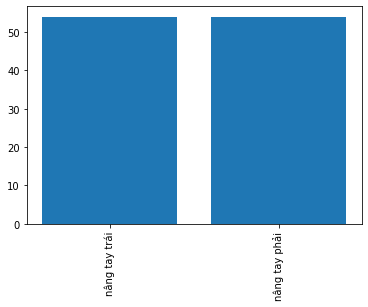

In [3]:
%%time
subjects_scenarios = load_subjects(data_dir)
print(f"found {len(subjects_scenarios)} subjects")

scenario_count = dict()
for _, scenarios in subjects_scenarios:
    for scenario in scenarios:
        if scenario in scenario_count:
            scenario_count[scenario] += 1
        else:
            scenario_count[scenario] = 1

plt.bar(scenario_count.keys(), scenario_count.values())
plt.xticks(rotation='vertical')

In [4]:
os.makedirs("./data", exist_ok=True)
for subject, _ in tqdm(subjects_scenarios):
    os.makedirs(f"./data/{subject}", exist_ok=True)
    copyfile(f"{data_dir}/{subject}/info.json", f"./data/{subject}/info.json")
    for sample_dir in glob.glob(f"{data_dir}/{subject}/sample*"):
        sample_name = sample_dir.split("/")[-1]
        if os.path.exists(f"{sample_dir}/eeg.json") and os.path.exists(f"{sample_dir}/EEG.edf"):
            os.makedirs(f"./data/{subject}/{sample_name}", exist_ok=True)
            copyfile(f"{sample_dir}/eeg.json", f"./data/{subject}/{sample_name}/eeg.json")
            copyfile(f"{sample_dir}/EEG.edf", f"./data/{subject}/{sample_name}/EEG.edf")

100%|██████████| 54/54 [00:00<00:00, 90.14it/s]


In [5]:
full_scenarios_subjects = list()
for subject, scenarios in subjects_scenarios:
    if len(scenarios) == 2:
        full_scenarios_subjects.append(subject)

print(f"{len(full_scenarios_subjects)} subjects: {sorted(full_scenarios_subjects)}")

54 subjects: ['ALS01_t1', 'ALS01_t10', 'ALS01_t2', 'ALS01_t3', 'ALS01_t4', 'ALS01_t5', 'ALS01_t6', 'ALS01_t7', 'ALS01_t8', 'ALS01_t9', 'ALS02_t1', 'ALS02_t10', 'ALS02_t2', 'ALS02_t3', 'ALS02_t4', 'ALS02_t5', 'ALS02_t6', 'ALS02_t7', 'ALS02_t8', 'ALS02_t9', 'ALS03_t1', 'ALS03_t10', 'ALS03_t2', 'ALS03_t3', 'ALS03_t4', 'ALS03_t5', 'ALS03_t6', 'ALS03_t7', 'ALS03_t8', 'ALS03_t9', 'ALS04_t1', 'ALS04_t10', 'ALS04_t2', 'ALS04_t3', 'ALS04_t4', 'ALS04_t5', 'ALS04_t6', 'ALS04_t7', 'ALS04_t8', 'ALS04_t9', 'ALS05_t1', 'ALS05_t2', 'ALS05_t3', 'ALS05_t4', 'ALS05_t5', 'ALS05_t6', 'ALS05_t7', 'ALS06_t1', 'ALS06_t2', 'ALS06_t3', 'ALS06_t4', 'ALS06_t6', 'ALS06_t7', 'ALS06_t8']


In [6]:
import mne

subjects = full_scenarios_subjects
subjects = sorted(subjects)
scenarios = [
    "nâng tay trái",
    "nâng tay phải"
]
events = [
    "Thinking",
    "Resting"
]

test_src_path = '/home/ducanh/hain/hungp/data_lab/als-patients/ALS01_t1/sample1/EEG.edf'
tgt_data = mne.io.read_raw_edf(test_src_path)
raw = tgt_data.get_data()
tgt_chans = tgt_data.ch_names

# tgt_chans = [
#     'Cz', 'CP1', 'CP2', 'Fz', 'FC1', 'FC2', 'Pz', 'C3', 'C4'
# ]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    "Resting": "other"
}

n_channels = len(tgt_chans)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.2  # @param

fmin = 4.0  # @param
fmax = 38.0  # @param

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=tgt_chans,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax,
    moving_standardize=True, 
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

using 32 channels


subject:   0%|          | 0/54 [00:00<?, ?it/s]/Data/home/ducanh/hain/hungp/NeurIPS_BEETL/data_util.py:174: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/Data/home/ducanh/hain/hungp/NeurIPS_BEETL/data_util.py:174: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/Data/home/ducanh/hain/hungp/NeurIPS_BEETL/data_util.py:174: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  13%|█▎        | 7/54 [00:00<00:00, 64.69it/s]/Data/home/ducanh/hain/hungp/NeurIPS_BEETL/data_util.py:174: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, v

/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/mne/viz/utils.py:1364: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('1.2.1'):
/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/mne/viz/utils.py:1364: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('1.2.1'):
/home/ducanh/anaconda3/envs/yolov4/lib/python3.8/site-packages/mne/viz/utils.py:1393: MatplotlibDeprecationWarning: The 'lineprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.lasso = LassoSelector(ax, onselect=self.on_select,


Text(0.5, 1.0, 'After channel selection projection')

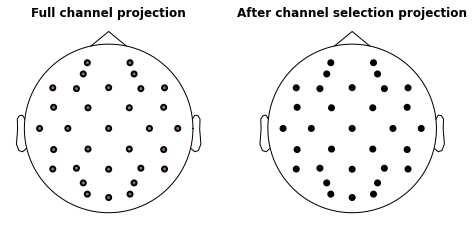

In [37]:
# # create a two-panel figure with some space for the titles at the top
# fig, ax = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw=dict(top=0.9),
#                        sharex=True, sharey=True)

# # we plot the channel positions with default sphere - the mne way
# fake_evoked.plot_sensors(ch_groups='position', axes=ax[0], show=False)

# # in the second panel we plot the positions using the EEGLAB reference sphere
# # fake_evoked.plot_sensors(sphere=(x, y, z, radius), axes=ax[1], show=False)
# fake_evoked.plot_sensors(kind='select',axes=ax[1], show=False)
# # add titles
# ax[0].set_title('Full channel projection', fontweight='bold')
# ax[1].set_title('After channel selection projection', fontweight='bold')

In [181]:
# aligned_ds = deepcopy(ds)
# for tgt_subject in subjects:
#     label_alignment(aligned_ds, target_subject=tgt_subject)
#     euclidean_alignment(aligned_ds, target_subject=tgt_subject)

In [182]:
skip_list = list()
skip_list = ['ALS03_t1', 'ALS03_t10', 'ALS03_t2', 'ALS03_t3', 'ALS03_t4', 'ALS03_t5', 'ALS03_t6', 'ALS03_t7', 'ALS03_t8', 'ALS03_t9', 
# 'ALS06_t1', 'ALS06_t2', 'ALS06_t3', 'ALS06_t4', 'ALS06_t6', 'ALS06_t7', 'ALS06_t8']
'ALS04_t3', 'ALS04_t4', 'ALS04_t5', 'ALS04_t6', 'ALS04_t7', 'ALS04_t8', 'ALS04_t9', 'ALS04_t10']

In [183]:
# for tgt_subject in subjects:
# label_alignment(ds, target_subject=subjects[30],skip_subjects=skip_list)
# euclidean_alignment(ds, skip_subjects=skip_list)

In [10]:
ds_info = ds.description
ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

# ds_info.sort_values("subject", ascending=False)[:12].sort_values("trial", ascending=False).sort_values("scenario", ascending=False)
ds_info.sort_values("epochs", ascending=False)

,subject,scenario,event,onset,label,label_idx,trial,split,epochs
217,ALS02_t9,nâng tay phải,Resting,30.8960,other,0,1,train,260
28,ALS01_t2,nâng tay phải,Resting,44.1282,other,0,1,train,78
438,ALS05_t1,nâng tay trái,Resting,37.4857,other,0,1,train,76
30,ALS01_t2,nâng tay phải,Resting,72.5144,other,0,2,train,69
1,ALS01_t1,nâng tay trái,Resting,26.3349,other,0,0,train,67
...,...,...,...,...,...,...,...,...,...
350,ALS04_t10,nâng tay phải,Resting,52.9216,other,0,2,train,11
298,ALS03_t6,nâng tay phải,Resting,50.1957,other,0,2,train,11
177,ALS02_t5,nâng tay phải,Resting,51.9656,other,0,2,train,11
455,ALS05_t2,nâng tay trái,Resting,11.5817,other,0,0,train,11


In [185]:
# remove noise
# ds_info.drop([217], inplace=True)
ds_info.drop(ds_info[ds_info['label'] == 'nâng tay trái'].index, inplace=True)

# ds_info.drop(ds_info[ds_info['subject'].str.contains('ALS03')].index, inplace=True)

ds_info.sort_values("epochs", ascending=False)

,subject,scenario,event,onset,label,label_idx,trial,split,epochs
13,K309,nâng tay phải,Resting,40.8268,other,0,2,train,28
15,K309,nâng tay phải,Thinking,62.1533,nâng tay phải,1,2,train,26
16,K309,nâng tay phải,Resting,69.1512,other,0,4,train,25
9,K309,nâng tay phải,Thinking,9.6537,nâng tay phải,1,0,train,24
7,K309,nâng tay trái,Resting,66.0653,other,0,4,train,23
12,K309,nâng tay phải,Thinking,34.4612,nâng tay phải,1,1,train,23
14,K309,nâng tay phải,Resting,55.8217,other,0,3,train,23
1,K309,nâng tay trái,Resting,14.7153,other,0,0,train,22
10,K309,nâng tay phải,Resting,16.2016,other,0,0,train,22
17,K309,nâng tay phải,Resting,83.4957,other,0,5,train,22


In [186]:
df_info = ds_info.sort_values("subject", ascending=True)
df_info

# test_data = ds_info[ds_info['subject'].str.contains('ALS06')] 
# test_data['epochs'].count()

,subject,scenario,event,onset,label,label_idx,trial,split,epochs
1,K309,nâng tay trái,Resting,14.7153,other,0,0,train,22
2,K309,nâng tay trái,Resting,29.2437,other,0,1,train,20
4,K309,nâng tay trái,Resting,41.1727,other,0,2,train,21
5,K309,nâng tay trái,Resting,54.4019,other,0,3,train,18
7,K309,nâng tay trái,Resting,66.0653,other,0,4,train,23
8,K309,nâng tay trái,Resting,79.7444,other,0,5,train,14
9,K309,nâng tay phải,Thinking,9.6537,nâng tay phải,1,0,train,24
10,K309,nâng tay phải,Resting,16.2016,other,0,0,train,22
11,K309,nâng tay phải,Resting,29.1802,other,0,1,train,17
12,K309,nâng tay phải,Thinking,34.4612,nâng tay phải,1,1,train,23


In [187]:
total_trials = ds_info['epochs'].sum()
train_trials = int(total_trials * 8 / 10)
# test_trails = total_trials - train_trials - val_trails

test_trails, val_trails = total_trials - train_trials, total_trials - train_trials

print(train_trials, test_trails, val_trails)


262 66 66


In [190]:
# test_data = ds_info[ds_info['subject'].str.contains('ALS04_t3|ALS04_t4|ALS04_t5|ALS04_t6|ALS04_t7|ALS04_t8|ALS04_t9|ALS04_t10')]
test_data = ds_info[ds_info['subject'].str.contains('K309')]
print(test_data['epochs'].sum())

test_labels = []
for i, r in test_data.iterrows():
    test_labels.extend([ds_info.loc[i, 'label']] * ds_info.loc[i, 'epochs']) 

val_data = ds_info[ds_info['subject'].str.contains('K309')]
print(val_data['epochs'].sum())

val_labels = []
for i, r in val_data.iterrows():
    val_labels.extend([ds_info.loc[i, 'label']] * ds_info.loc[i, 'epochs']) 

train_data = ds_info.drop(ds_info[ds_info['subject'].str.contains('ALS06')].index |
                        ds_info[ds_info['subject'].str.contains('ALS06')].index)
print(train_data['epochs'].sum())

train_labels = []

for i, r in train_data.iterrows():
    train_labels.extend([ds_info.loc[i, 'label']] * ds_info.loc[i, 'epochs']) 

328
328
328


/tmp/ipykernel_833722/1014751370.py:16: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  train_data = ds_info.drop(ds_info[ds_info['subject'].str.contains('ALS06')].index |


In [191]:
# concat dataset
data_type = [train_data, test_data, val_data]

X_train = np.concatenate([ds.datasets[i].windows.get_data() for i, r in train_data.iterrows()], dtype=np.float16)
X_test = np.concatenate([ds.datasets[i].windows.get_data() for i, r in test_data.iterrows()], dtype=np.float16)
X_val = np.concatenate([ds.datasets[i].windows.get_data() for i, r in val_data.iterrows()], dtype=np.float16)

In [192]:
# def relabel(str_label):
#     if str_label == 'nâng tay trái':
#         return 0
#     elif str_label == 'nâng tay phải':
#         return 1 
#     else:
#         return 2

def relabel(str_label):
    if str_label == 'nâng tay phải':
        return 0
    else:
        return 1 

y_train = np.array([relabel(label) for label in train_labels], dtype=np.int8)
y_test = np.array([relabel(label) for label in test_labels], dtype=np.int8)
y_val = np.array([relabel(label) for label in val_labels], dtype=np.int8)

In [193]:
np.save(f'{save_root}/X_train.npy', X_train)
np.save(f'{save_root}/X_val.npy', X_val)
np.save(f'{save_root}/X_test.npy', X_test)

np.save(f'{save_root}/y_train.npy', y_train)
np.save(f'{save_root}/y_val.npy', y_val)
np.save(f'{save_root}/y_test.npy', y_test)

In [196]:
test_df = ds_info[ds_info['label'] == 'nâng tay phải']
test_df

,subject,scenario,event,onset,label,label_idx,trial,split,epochs
9,K309,nâng tay phải,Thinking,9.6537,nâng tay phải,1,0,train,24
12,K309,nâng tay phải,Thinking,34.4612,nâng tay phải,1,1,train,23
15,K309,nâng tay phải,Thinking,62.1533,nâng tay phải,1,2,train,26
